### Data Download

In [2]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

--2025-03-08 11:34:51--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  6.46MB/s    in 5.4s    

2025-03-08 11:34:57 (5.33 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facades/te

### Data Visualization

Shape of the image:  (256, 512, 3)


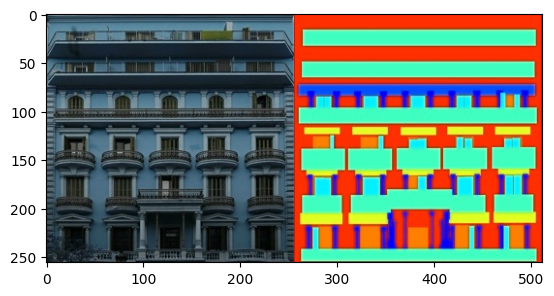

In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import neptune
import glob as glob
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


path = "facades/train/"
plt.imshow(cv2.imread(f"{path}20.jpg"))
print('Shape of the image: ',cv2.imread(f'{path}20.jpg').shape)

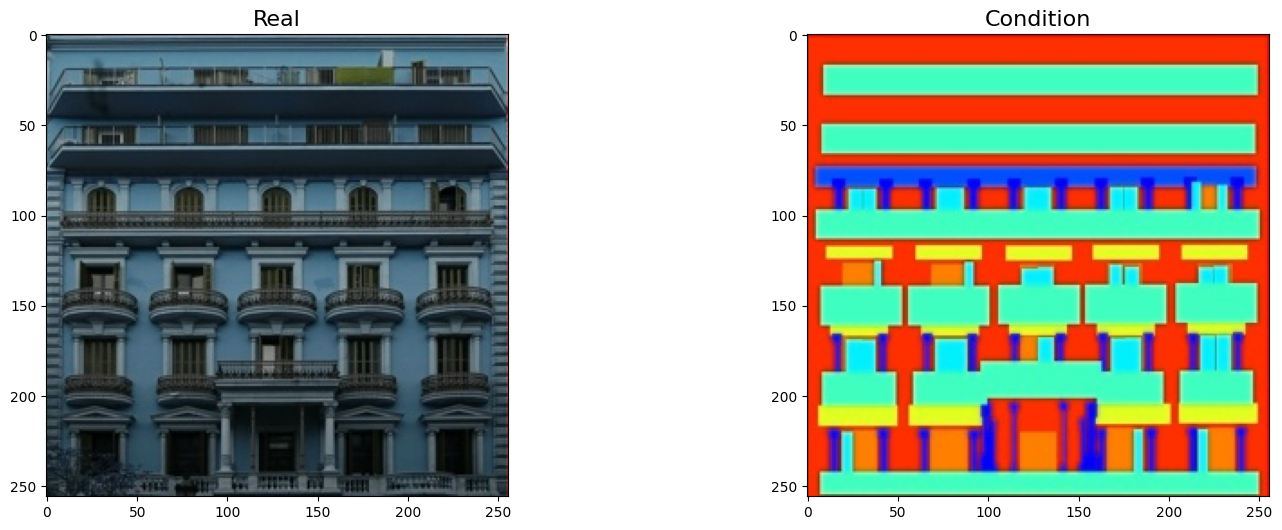

In [2]:
# Dividing the image by width
image = cv2.imread(f'{path}20.jpg')
w = image.shape[1]//2
image_real = image[:, :w, :]
image_cond = image[:, w:, :]
fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].imshow(image_real, label='Real')
axes[0].set_title('Real', fontsize=16)
axes[1].imshow(image_cond, label='Condition')
axes[1].set_title('Condition', fontsize=16)
plt.show()

### Creating dataloader

In [3]:
class Data(Dataset):
   def __init__(self, path="facades/train/"):
       self.filenames = glob.glob(path + "*.jpg")

   def __len__(self):
       return len(self.filenames)

   def __getitem__(self, idx):
       filename = self.filenames[idx]

       image = cv2.imread(filename)
       image_width = image.shape[1]
       image_width = image_width // 2
       real = image[:, :image_width, :]
       condition = image[:, image_width:, :]

       real = transforms.functional.to_tensor(real)
       condition = transforms.functional.to_tensor(condition)

       return real, condition

In [4]:
train_dataset = Data()
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = Data(path="facades/val/")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

### Creating components that will be used to build the Generator and Discriminator

In [5]:
def cnn_block(
   in_channels, out_channels, kernel_size, stride = 1, padding = 0, first_layer = False
):

   if first_layer:
       return nn.Conv2d(
           in_channels, out_channels, kernel_size, stride = stride, padding = padding
       )
   else:
       return nn.Sequential(
           nn.Conv2d(
               in_channels, out_channels, kernel_size, stride = stride, padding = padding
           ),
           nn.BatchNorm2d(out_channels, momentum = 0.1, eps = 1e-5),
       )


def tcnn_block(
   in_channels,
   out_channels,
   kernel_size,
   stride = 1,
   padding = 0,
   output_padding = 0,
   first_layer = False,
):
   if first_layer:
       return nn.ConvTranspose2d(
           in_channels,
           out_channels,
           kernel_size,
           stride = stride,
           padding = padding,
           output_padding = output_padding,
       )

   else:
       return nn.Sequential(
           nn.ConvTranspose2d(
               in_channels,
               out_channels,
               kernel_size,
               stride = stride,
               padding = padding,
               output_padding = output_padding,
           ),
           nn.BatchNorm2d(out_channels, momentum = 0.1, eps = 1e-5),
       )

### Parameters

In [6]:
batch_size = 4
workers = 2
epochs = 500
gf_dim = 64
df_dim = 64
L1_lambda = 100.0
in_w = in_h = 256
c_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Generator

In [7]:
class Generator(nn.Module):
 def __init__(self,instance_norm=False): #input : 256x256
   super(Generator,self).__init__()
   self.e1 = cnn_block(c_dim,gf_dim,4,2,1, first_layer = True)
   self.e2 = cnn_block(gf_dim,gf_dim*2,4,2,1,)
   self.e3 = cnn_block(gf_dim*2,gf_dim*4,4,2,1,)
   self.e4 = cnn_block(gf_dim*4,gf_dim*8,4,2,1,)
   self.e5 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,)
   self.e6 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,)
   self.e7 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,)
   self.e8 = cnn_block(gf_dim*8,gf_dim*8,4,2,1, first_layer=True)

   self.d1 = tcnn_block(gf_dim*8,gf_dim*8,4,2,1)
   self.d2 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1)
   self.d3 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1)
   self.d4 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1)
   self.d5 = tcnn_block(gf_dim*8*2,gf_dim*4,4,2,1)
   self.d6 = tcnn_block(gf_dim*4*2,gf_dim*2,4,2,1)
   self.d7 = tcnn_block(gf_dim*2*2,gf_dim*1,4,2,1)
   self.d8 = tcnn_block(gf_dim*1*2,c_dim,4,2,1, first_layer = True)#256x256
   self.tanh = nn.Tanh()

 def forward(self,x):
   e1 = self.e1(x)
   e2 = self.e2(F.leaky_relu(e1,0.2))
   e3 = self.e3(F.leaky_relu(e2,0.2))
   e4 = self.e4(F.leaky_relu(e3,0.2))
   e5 = self.e5(F.leaky_relu(e4,0.2))
   e6 = self.e6(F.leaky_relu(e5,0.2))
   e7 = self.e7(F.leaky_relu(e6,0.2))
   e8 = self.e8(F.leaky_relu(e7,0.2))
   d1 = torch.cat([F.dropout(self.d1(F.relu(e8)),0.5,training=True),e7],1)
   d2 = torch.cat([F.dropout(self.d2(F.relu(d1)),0.5,training=True),e6],1)
   d3 = torch.cat([F.dropout(self.d3(F.relu(d2)),0.5,training=True),e5],1)
   d4 = torch.cat([self.d4(F.relu(d3)),e4],1)
   d5 = torch.cat([self.d5(F.relu(d4)),e3],1)
   d6 = torch.cat([self.d6(F.relu(d5)),e2],1)
   d7 = torch.cat([self.d7(F.relu(d6)),e1],1)
   d8 = self.d8(F.relu(d7))

   return self.tanh(d8)

### Discriminator

In [8]:
class Discriminator(nn.Module):
 def __init__(self,instance_norm=False):#input : 256x256
   super(Discriminator,self).__init__()
   self.conv1 = cnn_block(c_dim*2,df_dim,4,2,1, first_layer=True) # 128x128
   self.conv2 = cnn_block(df_dim,df_dim*2,4,2,1)# 64x64
   self.conv3 = cnn_block(df_dim*2,df_dim*4,4,2,1)# 32 x 32
   self.conv4 = cnn_block(df_dim*4,df_dim*8,4,1,1)# 31 x 31
   self.conv5 = cnn_block(df_dim*8,1,4,1,1, first_layer=True)# 30 x 30

   self.sigmoid = nn.Sigmoid()
 def forward(self, x, y):
   O = torch.cat([x,y],dim=1)
   O = F.leaky_relu(self.conv1(O),0.2)
   O = F.leaky_relu(self.conv2(O),0.2)
   O = F.leaky_relu(self.conv3(O),0.2)
   O = F.leaky_relu(self.conv4(O),0.2)
   O = self.conv5(O)

   return self.sigmoid(O)

### Initializing the models


In [9]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=2e-4,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(), lr=2e-4,betas=(0.5,0.999))

bce_criterion = nn.BCELoss()
L1_criterion = nn.L1Loss()

In [10]:
run = neptune.init_run(
    project="ofekber/Project",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlMTc1ZWQ4OC00MmRlLTQwOTAtYjRjNi01OGE3NmQ2MjhiYzgifQ==",
)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ofekber/Project/e/PROJ-36


In [11]:
# Logging parameter in Neptune
PARAMS = {'Epoch': epochs,
         'Batch Size': batch_size,
         'Input Channels': c_dim,

         'Workers': workers,
         'Optimizer': 'Adam',
         'Learning Rate': 2e-4,
         'Metrics': ['Binary Cross Entropy', 'L1 Loss'],
         'Activation': ['Leaky Relu', 'Tanh', 'Sigmoid' ],
         'Device': device}

run['parameters'] = PARAMS

[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torch.device'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type


In [12]:
epochs = 500  
L1_lambda = 100
G_losses = []
D_losses = []
G_GAN_losses = []
G_L1_losses = []
img_list = []

# Assuming fixed_x and fixed_y are not defined, let's create them
fixed_x, fixed_y = next(iter(train_loader))
fixed_x = fixed_x.to(device)
fixed_y = fixed_y.to(device)

for ep in range(500):
    for i, data in enumerate(train_loader):

        y, x = data
        x = x.to(device)
        y = y.to(device)

        b_size = x.shape[0]

        real_class = torch.ones(b_size, 1, 30, 30).to(device)
        fake_class = torch.zeros(b_size, 1, 30, 30).to(device)

        # Train D
        D.zero_grad()

        real_patch = D(y, x)
        real_gan_loss = bce_criterion(real_patch, real_class)

        fake = G(x)

        fake_patch = D(fake.detach(), x)
        fake_gan_loss = bce_criterion(fake_patch, fake_class)

        D_loss = real_gan_loss + fake_gan_loss
        D_loss.backward()
        D_optimizer.step()

        # Train G
        G.zero_grad()
        fake_patch = D(fake, x)
        fake_gan_loss = bce_criterion(fake_patch, real_class)

        L1_loss = L1_criterion(fake, y)
        G_loss = fake_gan_loss + L1_lambda * L1_loss
        G_loss.backward()

        G_optimizer.step()

        # Neptune logging
        run["Gen Loss"].append(G_loss.item())
        run["Dis Loss"].append(D_loss.item())
        run["L1 Loss"].append(L1_loss.item())
        run["Gen GAN Loss"].append(fake_gan_loss.item())

        if (i + 1) % 50 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f},D(real): {:.2f}, D(fake):{:.2f},g_loss_gan:{:.4f},g_loss_L1:{:.4f}".format(
                    ep,
                    epochs,
                    i + 1,
                    len(train_loader),
                    D_loss.item(),
                    G_loss.item(),
                    real_patch.mean(),
                    fake_patch.mean(),
                    fake_gan_loss.item(),
                    L1_loss.item(),
                )
            )
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            G_GAN_losses.append(fake_gan_loss.item())
            G_L1_losses.append(L1_loss.item())

            with torch.no_grad():
                G.eval()
                fake = G(fixed_x).detach().cpu()
                G.train()
            figs = plt.figure(figsize=(10, 10))
            plt.subplot(1, 3, 1)
            plt.axis("off")
            plt.title("conditional image (x)")
            plt.imshow(
                np.transpose(
                    torchvision.utils.make_grid(fixed_x.cpu(), nrow=1, padding=5, normalize=True),
                    (1, 2, 0),
                )
            )

            plt.subplot(1, 3, 2)
            plt.axis("off")
            plt.title("fake image")
            plt.imshow(
                np.transpose(
                    torchvision.utils.make_grid(fake, nrow=1, padding=5, normalize=True),
                    (1, 2, 0),
                )
            )

            plt.subplot(1, 3, 3)
            plt.axis("off")
            plt.title("ground truth (y)")
            plt.imshow(
                np.transpose(
                    torchvision.utils.make_grid(fixed_y.cpu(), nrow=1, padding=5, normalize=True),
                    (1, 2, 0),
                )
            )

            run["epoch_original_results"].upload(figs)
            plt.close()
            img_list.append(figs)

Epoch [0/500], Step [50/100], d_loss: 0.0842, g_loss: 26.0420,D(real): 0.96, D(fake):0.03,g_loss_gan:3.6943,g_loss_L1:0.2235
Epoch [0/500], Step [100/100], d_loss: 0.2007, g_loss: 21.3050,D(real): 0.87, D(fake):0.04,g_loss_gan:3.4019,g_loss_L1:0.1790
Epoch [1/500], Step [50/100], d_loss: 0.4183, g_loss: 19.9321,D(real): 0.83, D(fake):0.28,g_loss_gan:1.3977,g_loss_L1:0.1853
Epoch [1/500], Step [100/100], d_loss: 0.6620, g_loss: 24.9448,D(real): 0.71, D(fake):0.20,g_loss_gan:2.6314,g_loss_L1:0.2231
Epoch [2/500], Step [50/100], d_loss: 2.7972, g_loss: 26.5948,D(real): 0.97, D(fake):0.05,g_loss_gan:3.7687,g_loss_L1:0.2283
Epoch [2/500], Step [100/100], d_loss: 0.1155, g_loss: 21.0503,D(real): 0.92, D(fake):0.03,g_loss_gan:3.7589,g_loss_L1:0.1729
Epoch [3/500], Step [50/100], d_loss: 0.4483, g_loss: 19.7922,D(real): 0.76, D(fake):0.13,g_loss_gan:2.1280,g_loss_L1:0.1766
Epoch [3/500], Step [100/100], d_loss: 0.1356, g_loss: 23.4328,D(real): 0.95, D(fake):0.05,g_loss_gan:3.3338,g_loss_L1:0.2

# Altered Architecture

### New Neptune project to monitor and plot losses

In [13]:
# Logging parameter in Neptune
PARAMS = {'Epoch': epochs,
         'Batch Size': batch_size,
         'Input Channels': c_dim,

         'Workers': workers,
         'Optimizer': 'Adam',
         'Learning Rate': 2e-4,
         'Metrics': ['Binary Cross Entropy', 'Cosine Loss'],
         'Activation': ['Leaky Relu', 'Tanh', 'Sigmoid' ],
         'Device': device}

run['parameters'] = PARAMS

In [14]:
cosine_sim = nn.CosineSimilarity(dim=1, eps=1e-8)

def cosine_loss(fake, real):
    """
    Computes 1 - CosineSimilarity over the batch.
    This is higher when 'fake' and 'real' differ in 'direction'
    and is 0 if they are perfectly identical in direction.
    """
    # Flatten to (batch_size, num_pixels)
    fake_flat = fake.view(fake.size(0), -1)
    real_flat = real.view(real.size(0), -1)

    # Similarities shape: (batch_size,)
    similarities = cosine_sim(fake_flat, real_flat)

    # Convert similarity to "dissimilarity"
    # If similarity=1 => loss=0, if similarity=-1 => loss=2
    loss = 1 - similarities

    # Average across the batch
    return loss.mean()

In [15]:
epochs = 500  
L1_lambda = 100
G_losses = []
D_losses = []
G_GAN_losses = []
G_L1_losses = []
img_list = []

# Just an example. 
fixed_x, fixed_y = next(iter(train_loader))
fixed_x = fixed_x.to(device)
fixed_y = fixed_y.to(device)

for ep in range(500):
    for i, data in enumerate(train_loader):
        y, x = data
        x = x.to(device)
        y = y.to(device)

        b_size = x.shape[0]

        real_class = torch.ones(b_size, 1, 30, 30).to(device)
        fake_class = torch.zeros(b_size, 1, 30, 30).to(device)

        # ---------------------
        # 1) Train D
        # ---------------------
        D.zero_grad()

        real_patch = D(y, x)
        real_gan_loss = bce_criterion(real_patch, real_class)

        fake = G(x)
        fake_patch = D(fake.detach(), x)
        fake_gan_loss = bce_criterion(fake_patch, fake_class)

        D_loss = real_gan_loss + fake_gan_loss
        D_loss.backward()
        D_optimizer.step()

        # ---------------------
        # 2) Train G
        # ---------------------
        G.zero_grad()

        # The generator wants the "fake_patch" to appear real
        fake_patch = D(fake, x)
        fake_gan_loss = bce_criterion(fake_patch, real_class)

        # >>> Replace L1 with Cosine-based reconstruction <<<
        # old: L1_loss = L1_criterion(fake, y)
        # now:
        cos_loss = cosine_loss(fake, y)   # <- our new loss function

        # Combine them
        G_loss = fake_gan_loss + L1_lambda * cos_loss
        G_loss.backward()
        G_optimizer.step()

        # (Optional) Logging to Neptune or console
        run["Gen_Cos Loss"].append(G_loss.item())
        run["Dis_Cos Loss"].append(D_loss.item())
        run["Cosine Loss"].append(cos_loss.item())  # new name if you want
        run["Gen GAN_Cos Loss"].append(fake_gan_loss.item())

        if (i + 1) % 50 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, "
                "D(real): {:.2f}, D(fake): {:.2f}, g_loss_gan: {:.4f}, cos_loss: {:.4f}".format(
                    ep, epochs, i + 1, len(train_loader),
                    D_loss.item(),
                    G_loss.item(),
                    real_patch.mean(),
                    fake_patch.mean(),
                    fake_gan_loss.item(),
                    cos_loss.item(),
                )
            )
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            G_GAN_losses.append(fake_gan_loss.item())
            # If you still want to track the new cos loss separately
            G_L1_losses.append(cos_loss.item())  

            with torch.no_grad():
                G.eval()
                fake = G(fixed_x).detach().cpu()
                G.train()

            figs = plt.figure(figsize=(10, 10))
            plt.subplot(1, 3, 1)
            plt.axis("off")
            plt.title("conditional image (x)")
            plt.imshow(
                np.transpose(
                    torchvision.utils.make_grid(fixed_x.cpu(), nrow=1, padding=5, normalize=True),
                    (1, 2, 0),
                )
            )

            plt.subplot(1, 3, 2)
            plt.axis("off")
            plt.title("fake image")
            plt.imshow(
                np.transpose(
                    torchvision.utils.make_grid(fake, nrow=1, padding=5, normalize=True),
                    (1, 2, 0),
                )
            )

            plt.subplot(1, 3, 3)
            plt.axis("off")
            plt.title("ground truth (y)")
            plt.imshow(
                np.transpose(
                    torchvision.utils.make_grid(fixed_y.cpu(), nrow=1, padding=5, normalize=True),
                    (1, 2, 0),
                )
            )

            run["epoch_cosine_results"].upload(figs)
            plt.close()
            img_list.append(figs)

Epoch [0/500], Step [50/100], d_loss: 0.0577, g_loss: 6.9425, D(real): 0.98, D(fake): 0.03, g_loss_gan: 4.1419, cos_loss: 0.0280
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: HTTPError
Epoch [0/500], Step [100/100], d_loss: 0.0506, g_loss: 9.6997, D(real): 0.96, D(fake): 0.00, g_loss_gan: 6.6312, cos_loss: 0.0307
Epoch [1/500], Step [50/100], d_loss: 0.7910, g_loss: 5.0413, D(real): 0.80, D(fake): 0.27, g_loss_gan: 3.1647, cos_loss: 0.0188
Epoch [1/500], Step [100/100], d_loss: 1.0511, g_loss: 6.7651, D(real): 0.99, D(fake): 0.03, g_loss_gan: 4.3565, cos_loss: 0.0241
Epoch [2/500], Step [50/100], d_loss: 0.1488, g_loss: 5.9110, D(real): 0.88, D(fake): 0.03, g_loss_gan: 4.1145, cos_loss: 0.0180
Epoch [2/500], Step [100/100], d_loss: 0.3985, g_loss: 3.7938, D(real): 0.75, D(fake): 0.17, g_loss_gan: 2.0550, cos_loss: 0.0174
Epoch [3/500], Step [50/100], d_loss: 0.1205, g_loss: 5.6086, D(real): 0.98, D

[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
[neptune] [info   ] Communication with Neptune restored!
[neptune] [info   ] Communication with Neptune restored!
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: HTTPError
[neptune] [info   ] Communication with Neptune restored!
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
[neptune] [info   ] Communication with Neptune restored!
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
[neptune] [info   ] Communication with Neptune restored!
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Intern

# Results

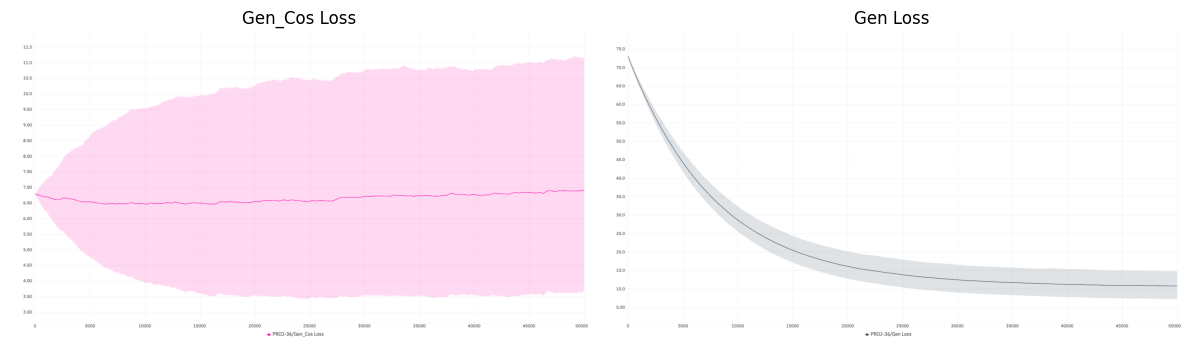

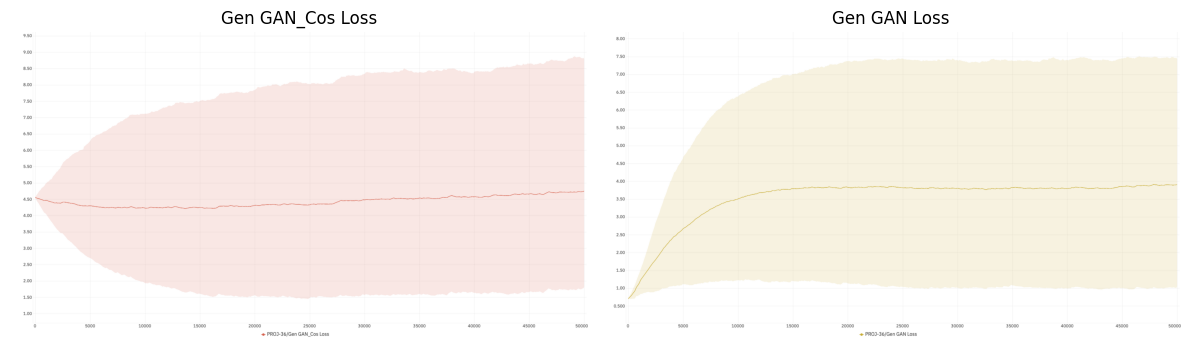

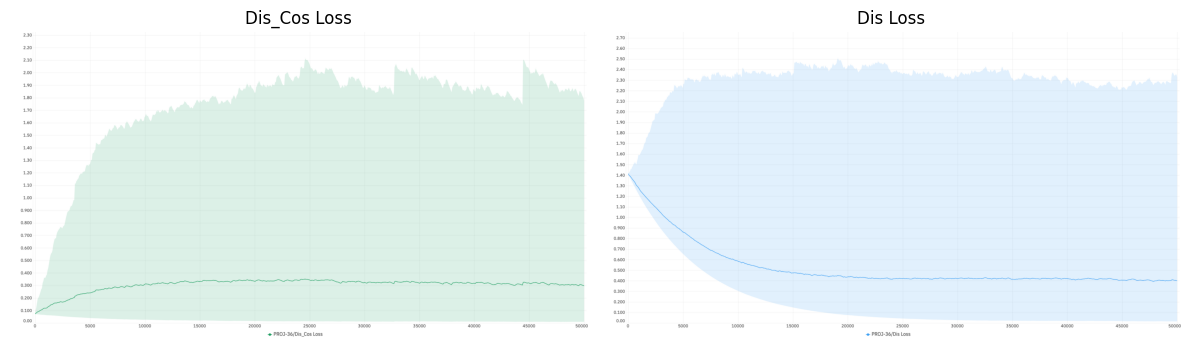

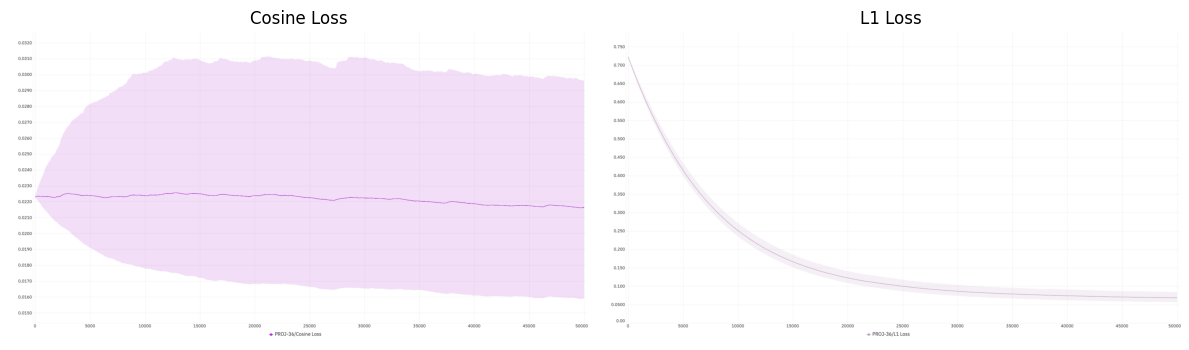

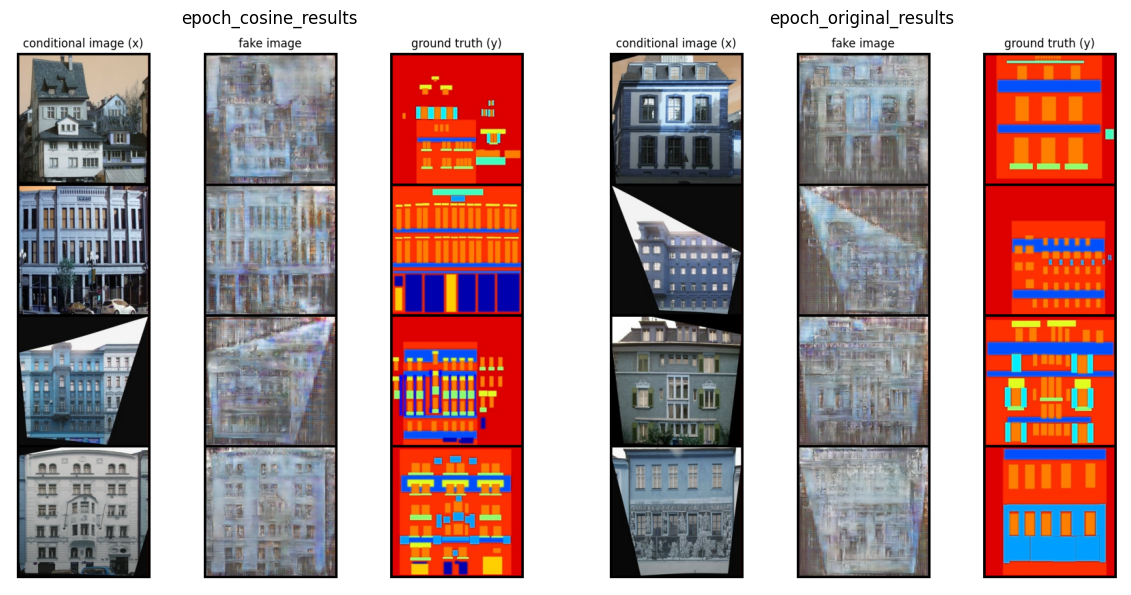

In [25]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder with your images
image_folder = "photos"

# Define pairs of images you want to show together
image_pairs = [
    ("Gen_Cos Loss.png", "Gen Loss.png"),
    ("Gen GAN_Cos Loss.png", "Gen GAN Loss.png"),
    ("Dis_Cos Loss.png", "Dis Loss.png"),
    ("Cosine Loss.png", "L1 Loss.png"),
    ("epoch_cosine_results.png", "epoch_original_results.png")
]

# Plotting each pair in a single row
for left_img, right_img in image_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # One row, two columns, larger size

    for ax, img_name in zip(axes, [left_img, right_img]):
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_name.replace(".png", ""), fontsize=12)

    plt.tight_layout()
    plt.show()
